In [1]:
from functions import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import pandas as pd
import verde as vd

from skimage.feature import blob_log
import skimage
import scipy.signal as signal

import mplstereonet as mpl


microm2m = 1.0E-6
m2microm = 1.0E6
# plt.rcParams["figure.figsize"] = (10,10)

In [2]:
import scipy.io as sio

mat_contents = sio.loadmat('Bz_uc0.mat')
print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Bt', 'Bz', 'corners', 'h', 'newLED', 'step'])


In [3]:
step = mat_contents['step'] # grid spacing
shape = np.shape(mat_contents['Bz']) # grid shape
data = mat_contents['Bz'] # 2D Bz data
sensor_sample_distance = mat_contents['h'] # sensor-sample distance

In [4]:
data = np.reshape(data, (np.size(data),1))
data_2D = np.reshape(data, shape)


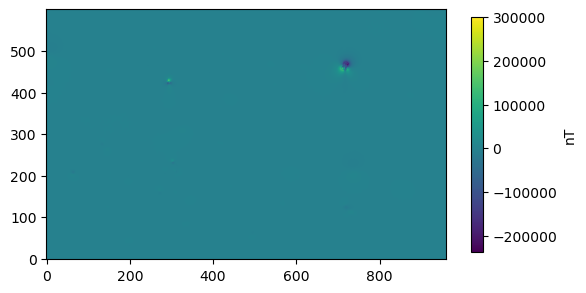

In [5]:
plt.figure(figsize=(6,5))
plt.imshow(data_2D*10**9, cmap='viridis')
plt.colorbar(shrink=0.5, label='nT')
plt.gca().invert_yaxis()

plt.tight_layout()

In [6]:
x_step = step
y_step = step

area = (0, (np.shape(data_2D)[0])*x_step, 0, (np.shape(data_2D)[1])*y_step)
z = - abs(sensor_sample_distance)

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A

In [7]:
data_2D_orig = np.copy(data_2D)
trend = vd.Trend(degree=6).fit((X.ravel(), Y.ravel()), data_2D.ravel())

In [8]:
data_2D -= trend.predict((X.ravel(), Y.ravel())).reshape(shape)

In [9]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

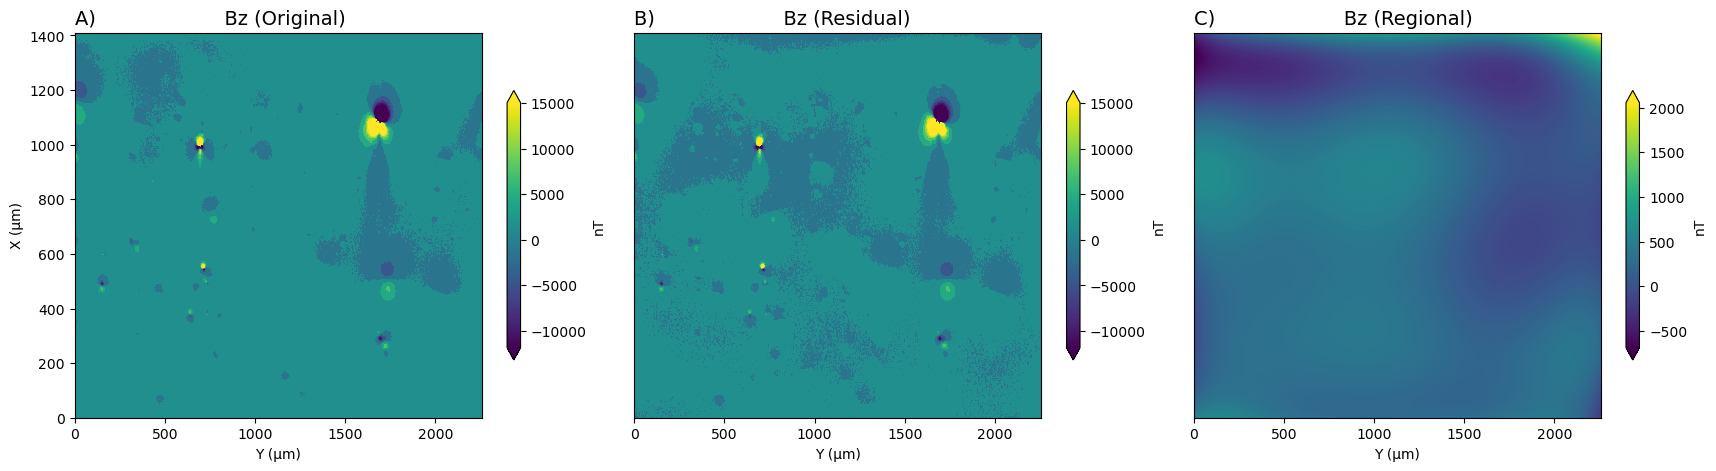

In [10]:
# create extent colorbars 
vmin1=np.min(data_2D_orig*10**9) * 0.05
vmax1=np.max(data_2D_orig*10**9) * 0.05
vmin2=np.min(data_2D*10**9) * 0.05
vmax2=np.max(data_2D*10**9) * 0.05

plt.figure(figsize=(.001,.001))
img1 = plt.imshow(data_2D_orig*10**9, cmap='viridis')
img1.set_clim(vmin1, vmax1)

img2 = plt.imshow(data_2D*10**9, cmap='viridis')
img2.set_clim(vmin2, vmax2)
img2.axes.get_xaxis().set_visible(False)
img2.axes.get_yaxis().set_visible(False)

regional_2D = (data_2D_orig-data_2D)

vmin3=np.min(regional_2D*10**9)*0.9 
vmax3=np.max(regional_2D*10**9)*0.9

img3 = plt.imshow(regional_2D*10**9, cmap='viridis')
img3.axes.get_xaxis().set_visible(False)
img3.axes.get_yaxis().set_visible(False)


#######
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(21,5))

# plot original data
ax1_plot = ax1.contourf(x_plot, y_plot, data_2D_orig*10**9, levels=200, cmap='viridis', 
             vmin=vmin1, vmax=vmax1, extend='both')
color_bar1 = plt.colorbar(img1, ax=ax1, label='nT', extend='both', shrink=0.7)
ax1.set_title('A)                     Bz (Original)', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)


# plot residual data
ax2_plot = ax2.contourf(x_plot, y_plot, data_2D*10**9, levels=200, cmap='viridis',
                       vmin=vmin2, vmax=vmax2, extend='both')
color_bar2 = plt.colorbar(img2, ax=ax2, label='nT', extend='both', shrink=0.7)
ax2.set_title('B)                     Bz (Residual)', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, regional_2D*10**9, levels=200, cmap='viridis',
                       vmin=vmin3, vmax=vmax3, extend='both')
plt.colorbar(img3, ax=ax3, label='nT', extend='both', shrink=0.7)
ax3.set_title('C)                     Bz (Regional)', fontsize=14, loc='left')
ax3.set_xlabel('Y (µm)', fontsize=10)


ax2.set_yticks([])
ax3.set_yticks([])
fig.subplots_adjust(wspace=0.1)

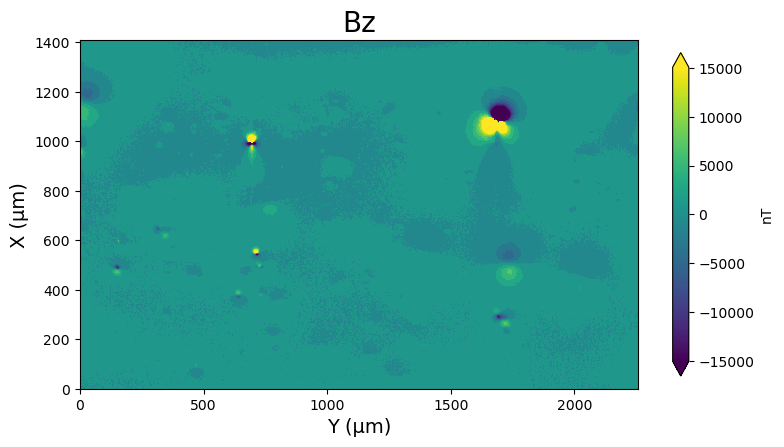

In [11]:
# Change the colorbar scale
# Plot data from the forward model

vmin=np.min(data_2D*10**9) * 0.05
vmax=np.max(data_2D*10**9) * 0.05

if abs(vmax) > abs(vmin):
    vmax = vmax
    vmin = -1*vmax
else:
    vmax = abs(vmin)
    vmin = vmin

plt.figure(figsize=(9,6))
fig = plt.imshow(data_2D*10**9, cmap='viridis')
plt.clim(vmin, vmax)
plt.contourf(x_plot, y_plot, data_2D*10**9, levels=300, cmap='viridis', 
             vmin=vmin, vmax=vmax, extend='both')
color_bar = plt.colorbar(fig, label='nT', extend='both', shrink=0.7)
plt.gca().invert_yaxis()


plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.show()

In [12]:
X_2D = np.reshape(X, shape)
Y_2D = np.reshape(Y, shape)
Z_2D = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(data_2D, X_2D, Y_2D)

X_derivative_FFT = x_derivative_fft(data_2D, wx, order=1)
Y_derivative_FFT = y_derivative_fft(data_2D, wy, order=1)
X_derivative_FFT = z_derivative_fft(data_2D, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
X_derivative_FD, Y_derivative_FD = (derivative_fd(data_2D, X_2D, Y_2D, order=1))

In [13]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(Y_derivative_FD , X_derivative_FD)
Horiz_Grad_FFT = Horiz_Grad(Y_derivative_FFT, X_derivative_FFT)

In [14]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(data_2D, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(data_2D, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(data_2D, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

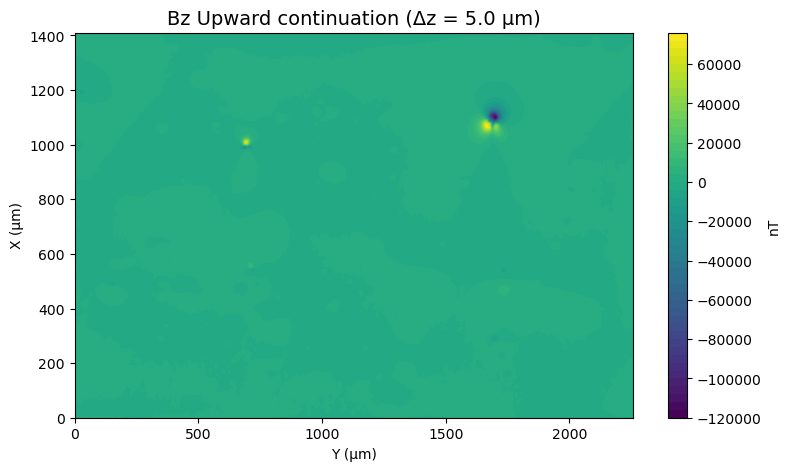

In [15]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)

In [16]:
# New derivatives by FFT
Y_derivative_FFT = y_derivative_fft(upward, wy)
X_derivative_FFT = x_derivative_fft(upward, wx)
Z_derivative_FFT = z_derivative_fft(upward, wz)

In [17]:
# New derivatives by FD
X_derivative_FD, Y_derivative_FD = (derivative_fd(upward, X_2D, Y_2D))
Z_derivative_FD = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

In [18]:
# total gradient data
Total_Grad_FD = Total_Grad(Y_derivative_FD , X_derivative_FD, Z_derivative_FD)
Total_Grad_FFT = Total_Grad(Y_derivative_FFT, X_derivative_FFT, Z_derivative_FFT)

# Euler solver

Text(0, 0.5, 'Count')

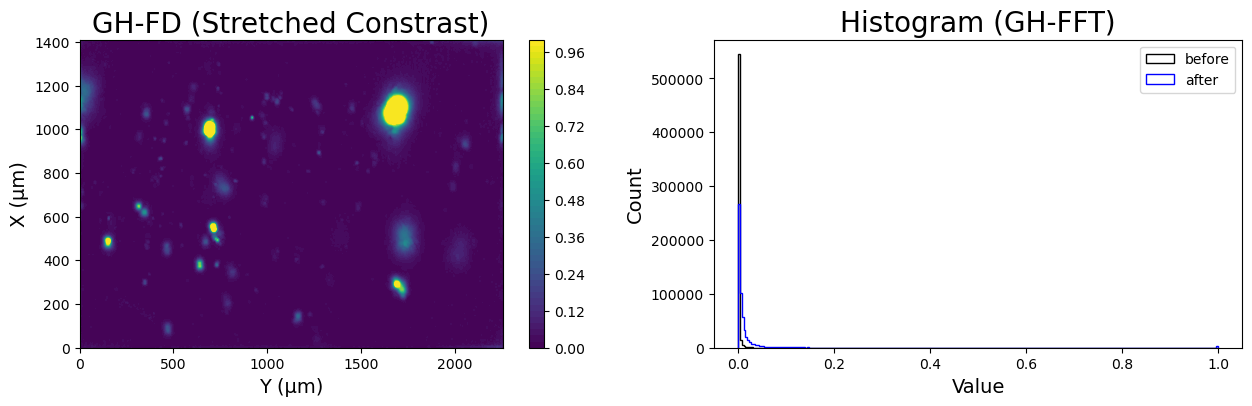

In [19]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


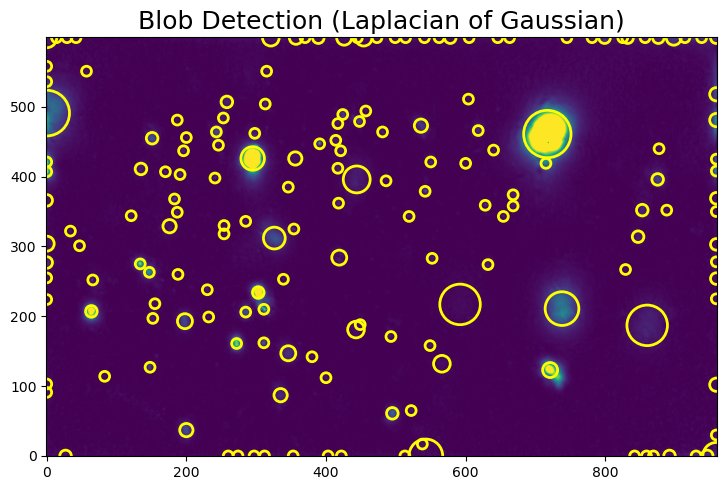

Sources found  =  85


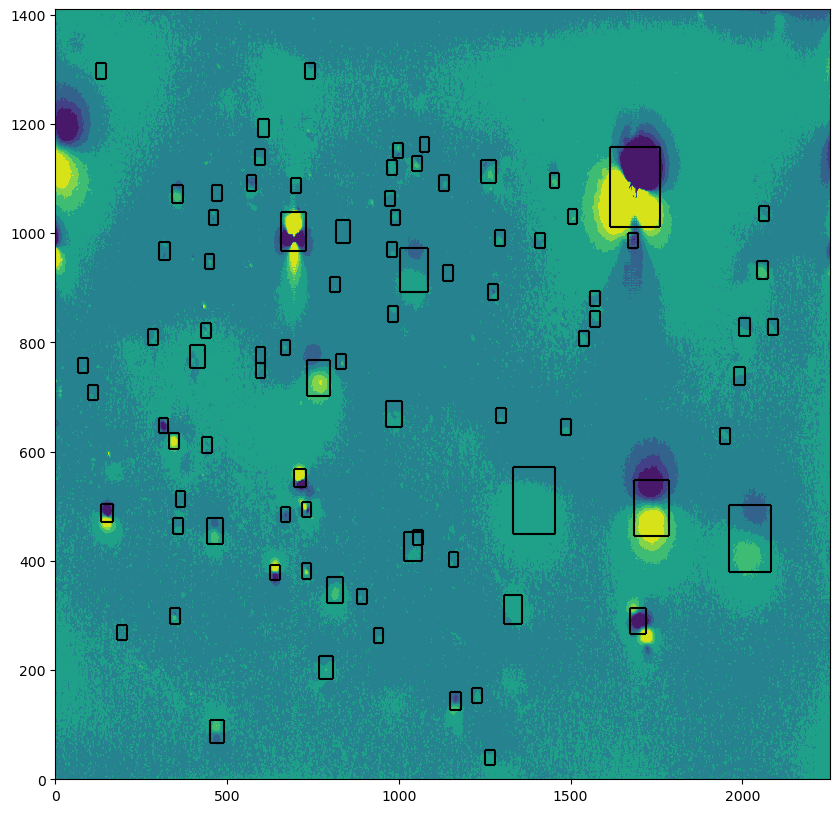

In [20]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.01, min_sigma=5, 
                                              max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=-0.1)

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_2D, Y_2D, Z_2D, upward,
                                                                     X_derivative_FD, Y_derivative_FD, Z_derivative_FD,
                                                                     delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(data_2D, (0.5,99.5))
view = skimage.exposure.rescale_intensity(data_2D, in_range=(perc_min, perc_max))
euler_windows_view(X_2D, Y_2D, Z_2D, view, filtered_euler_windows_FD, show_windows=False, color='k')


print('Sources found  = ', np.shape(filtered_euler_windows_FD)[0])

Euler Solutions:
      Xc (µm)    Yc (µm)  Zc (µm)
0   1086.1970  1687.1684  21.3284
1   1001.9306   691.5173   6.5106
2    548.9877   713.7814   5.0181
3    484.6537   152.0466  10.7902
4    288.1693  1692.4430  18.6692
..        ...        ...      ...
80   516.6675   362.7251   9.8956
81   704.0136   115.9527   7.8975
82   332.3934   894.5105   1.2234
83   922.4584  1142.3878   6.2431
84   991.0468  1418.1981   5.6792

[85 rows x 3 columns]



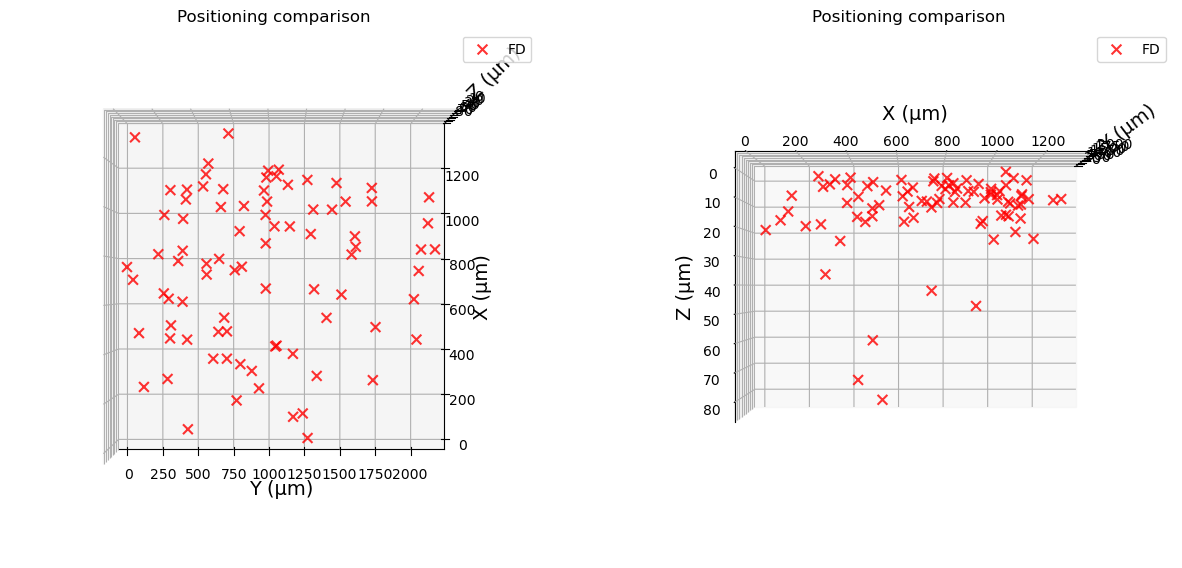

In [21]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()


from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90



ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()





# Magnetic inversion using lest square method

In [22]:
# set the noise level as the measurement standart deviation
noise_std_dev = 15.0e-9 # nT for the 'fixed method'

In [23]:


### Windows
windows_dataframe = window_least_square_solver(filtered_euler_windows_FD, X_2D, Y_2D, Z_2D, data_2D, upward, delta_z,
                                               X_derivative_FD, Y_derivative_FD, Z_derivative_FD, noise_std_dev, 
                                               structural_index=3, show=False)

### Windows with different upward level ###
# windows_dataframe = window_least_square_solver_new(filtered_euler_windows_FD, X_2D, Y_2D, Z_2D, data_2D, noise_std_dev,
#                                                    delta_z_list=np.linspace(2.0, 5.0, 20), show=False)


In [24]:
windows_dataframe.head()

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),mx ($A \cdot m^2$),my ($A \cdot m^2$),mz ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm),$R^2$
0,28.8917,0.0004,-16.7241,0.0003,3.230557e-11,2.211095e-16,2.708825e-11,1.494839e-11,-9.296364e-12,1086.196960,1687.168423,21.328358,0.706213
1,-174.1078,0.0012,21.7123,0.0009,2.162601e-12,4.163210e-17,-1.998556e-12,-2.062567e-13,8.000447e-13,1001.930607,691.517287,6.510633,0.814712
2,163.7010,0.0058,3.4048,0.0040,3.338284e-13,3.335353e-17,-3.198463e-13,9.352361e-14,1.982627e-14,548.987666,713.781405,5.018090,0.990692
3,3.6344,0.0123,-23.6428,0.0079,4.702128e-13,8.740487e-17,4.298784e-13,2.730465e-14,-1.885712e-13,484.653654,152.046629,10.790203,0.986446
4,51.3554,0.0314,-68.0578,0.0112,1.026307e-12,1.439110e-16,2.394915e-13,2.995276e-13,-9.519629e-13,288.169306,1692.443029,18.669161,0.807931


# Model x Recoverd Data Comparison

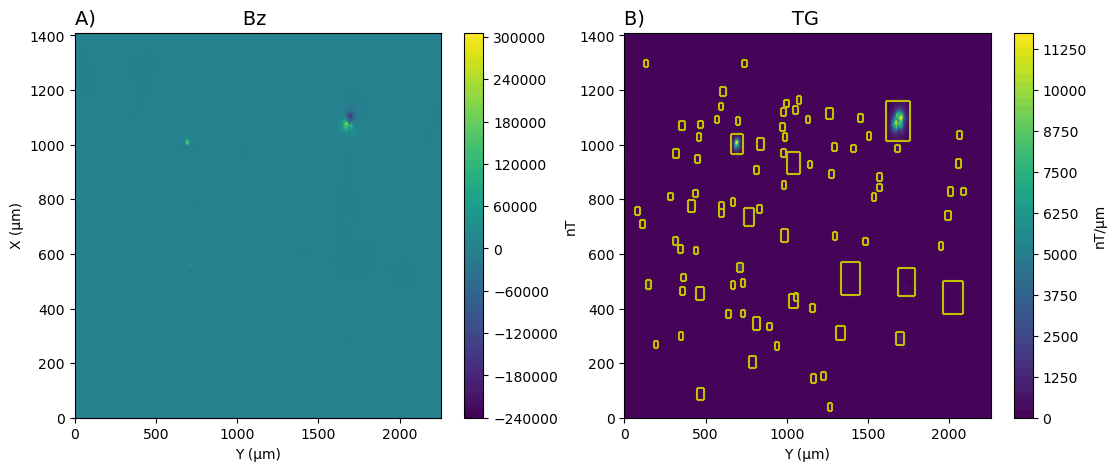

In [25]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, data_2D_orig*10**9, levels=100, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('A)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('B)                        TG', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(filtered_euler_windows_FD)[0]):
    x1 = int(filtered_euler_windows_FD[i,0]) * x_step
    x2 = int(filtered_euler_windows_FD[i,1]) * x_step
    y1 = int(filtered_euler_windows_FD[i,2]) * y_step
    y2 = int(filtered_euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)


In [26]:
D_FD_least = np.array(windows_dataframe[r'Dec (°)'])
sigma_D_FD_least = np.array(windows_dataframe[r'$\sigma D$ (°)'])

I_FD_least = np.array(windows_dataframe[r'Inc (°)'])
sigma_I_FD_least = np.array(windows_dataframe[r'$\sigma I$ (°)'])

momentum_FD_least = np.array(windows_dataframe[r'm  ($A \cdot m^2$)'])
sigma_m_FD_least = np.array(windows_dataframe[r'$\sigma m$ ($A \cdot m^2$)'])

Xc_FD = np.array(windows_dataframe[r'Xc (µm)'])
Yc_FD = np.array(windows_dataframe[r'Yc (µm)'])
Zc_FD = np.array(windows_dataframe[r'Zc (µm)'])

R2 = np.array(windows_dataframe[r'$R^2$'])


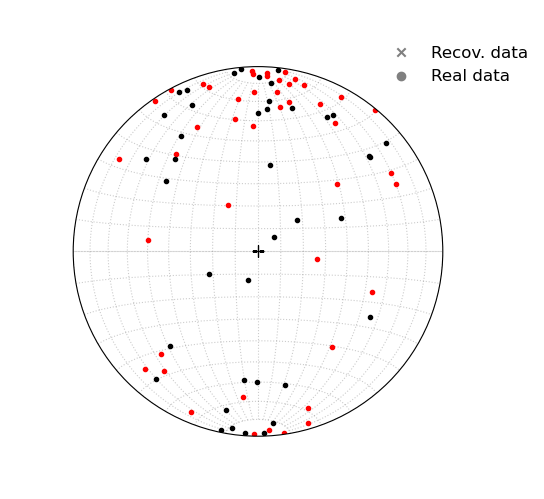

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
                
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if k == 0:
        ax.line(np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

    else:
        ax.line( np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

ax.line(90,90, marker='+', color='k', markersize=8) # center mark
ax.set_azimuth_ticks([])
ax.grid(which='both', linestyle=':', color='gray', alpha=0.4)

ax.scatter([],[], marker='x', color='gray', label='Recov. data')
ax.scatter([],[], marker='o', color='gray', label='Real data')

ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=12)

ax.plot();

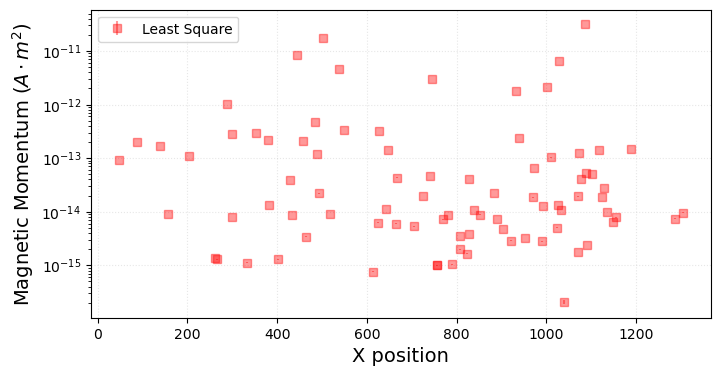

In [28]:
sources = np.copy(Xc_FD)

plt.figure(figsize=(8,4))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')


plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')


## Forward Model and Residuals

### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

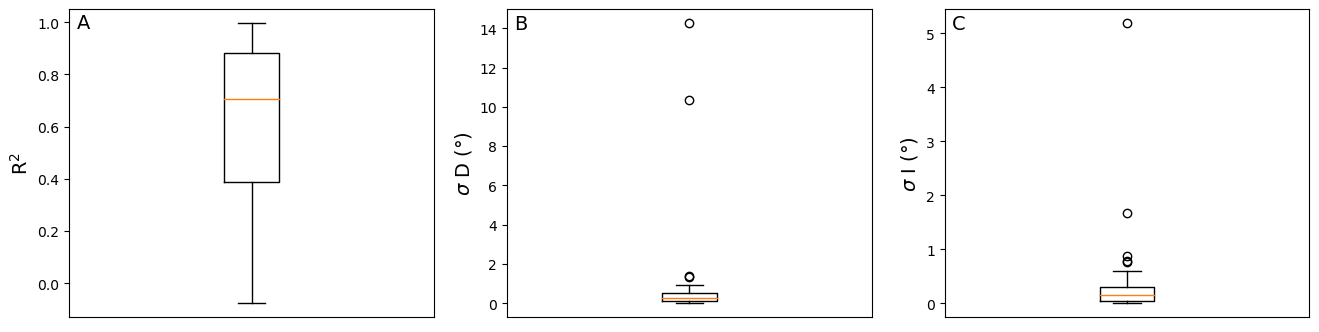

In [29]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(R2)
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = R2.max()
axes[0].text(0.52, ytext-0.02*ytext, 'A', fontsize=14)

axes[1].boxplot(sigma_D_FD_least)
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = sigma_D_FD_least.max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(sigma_I_FD_least)
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = sigma_I_FD_least.max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()


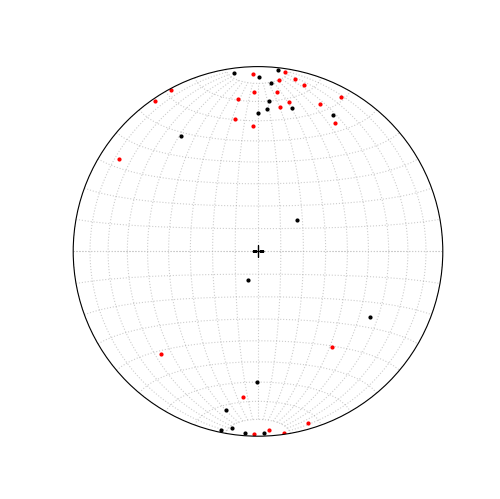

filtered sources =  44


In [30]:
cut_off_R2 = 0.7
index = ((windows_dataframe[r'$R^2$']>=cut_off_R2))
h=windows_dataframe[index]


D_filtered, I_filtered = directions(np.array(h[r'mx  ($A \cdot m^2$)']), np.array(h[r'my  ($A \cdot m^2$)']), 
                                    np.array(h[r'mz  ($A \cdot m^2$)']), plot=True, show_mean=False, show_alpha95=False)


mx_filtered = np.array(h[r'mx  ($A \cdot m^2$)'])
my_filtered = np.array(h[r'my  ($A \cdot m^2$)'])
mz_filtered = np.array(h[r'mz  ($A \cdot m^2$)'])


print('filtered sources = ', np.size(D_filtered))

#### Momentum Recovered

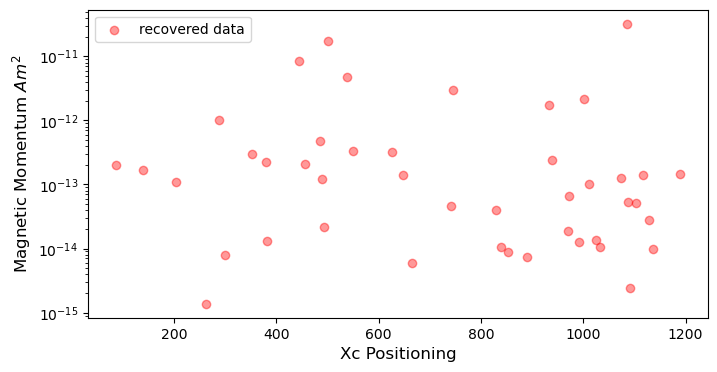

In [31]:
plt.figure(figsize=(8,4))
plt.scatter(h[r'Xc (µm)'], h[r'm  ($A \cdot m^2$)'], label='recovered data', alpha=0.4, color='r')


plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('Magnetic Momentum $Am^{2}$', fontsize=12)
plt.legend(loc='best')
plt.yscale('log')


# First Figure

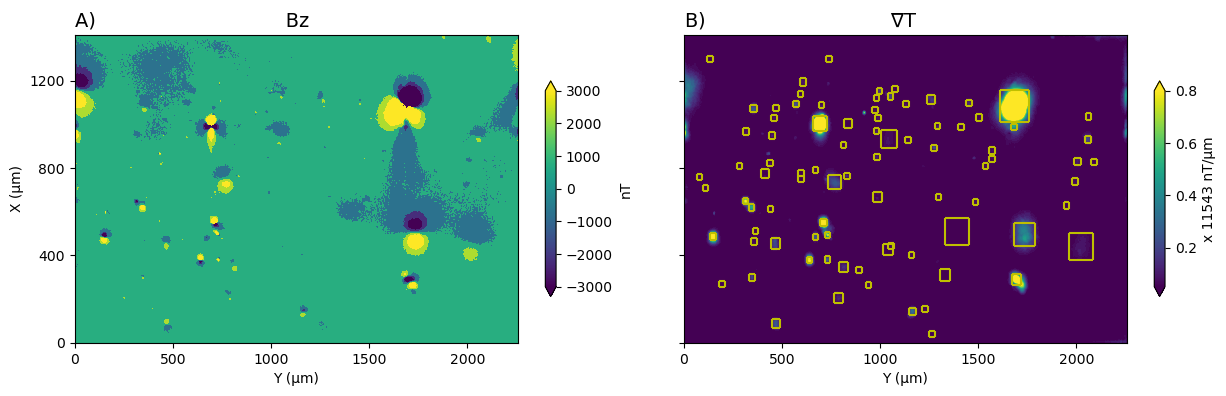

In [32]:
# create extent colorbars 
# vmin1=np.min(data_2D_orig*10**9) * 0.05
# vmax1=np.max(data_2D_orig*10**9) * 0.05

vmin1 = -3000
vmax1 =  3000
vmin2= 0.05
vmax2= 0.8     #np.max(stretched_image) * 1

plt.figure(figsize=(.001,.001))
img1 = plt.imshow(data_2D*10**9, cmap='viridis')
img1.set_clim(vmin1, vmax1)

img2 = plt.imshow(Total_Grad_FD*10**3, cmap='viridis')
img2.set_clim(vmin2, vmax2)
img2.axes.get_xaxis().set_visible(False)
img2.axes.get_yaxis().set_visible(False)

scale_max = int(np.max(Total_Grad_FD*10**3))

#### Real Figure ####
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

# plot original data
ax1_plot = ax1.contourf(x_plot, y_plot, data_2D_orig*10**9, levels=500, cmap='viridis', 
             vmin=vmin1, vmax=vmax1, extend='both')
color_bar1 = plt.colorbar(img1, ax=ax1, label='nT', extend='both', shrink=0.7)
ax1.set_title('A)                               Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)


# plot total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis',
                       vmin=vmin2, vmax=vmax2, extend='both')
color_bar2 = plt.colorbar(img2, ax=ax2, label='x %s nT/µm'%(str(scale_max)), extend='both', shrink=0.7)
ax2.set_title(r'B)                              $\nabla$T', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)


# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(filtered_euler_windows_FD)[0]):
    x1 = int(filtered_euler_windows_FD[i,0]) * x_step
    x2 = int(filtered_euler_windows_FD[i,1]) * x_step
    y1 = int(filtered_euler_windows_FD[i,2]) * y_step
    y2 = int(filtered_euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)

ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.set_yticks([0, 400, 800, 1200])
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.set_yticks(ticks=[0, 400, 800, 1200], labels=[])

fig.subplots_adjust(wspace=0.1)
    
image_name = 'RealData'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

# Second Figure

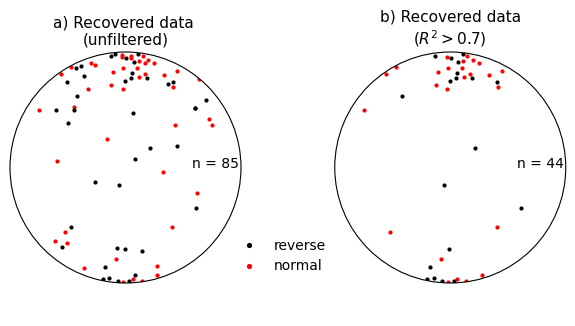

In [33]:
confidence=95

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(121, projection='stereonet')
ax2 = fig.add_subplot(122, projection='stereonet')


####### recovered directions #######
vector, stats = mpl.find_fisher_stats(I_FD_least, D_FD_least, conf=confidence)
for i in range(len(D_FD_least)):
    if I_FD_least[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax1.line(abs(I_FD_least[i]), D_FD_least[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I_FD_least, D_FD_least, conf=confidence)

# ax1.line(90,90, marker='+', color='k', markersize=8) # center mark
ax1.set_azimuth_ticks([])
# ax1.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax1.text(0.84, 0, 'n = '+str(np.size(D_FD_least)), fontsize=10)

# plot 1 statistics
# ax1.line(vector[0], vector[1], marker='o', color="green", markersize=4)
# ax1.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')
# # gives the a95 cone
# ax1.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
# ax1.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')



####### recovered directions filtered #######
vector, stats = mpl.find_fisher_stats(I_filtered, D_filtered, conf=confidence)
for i in range(len(D_filtered)):
    if I_filtered[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax2.line(abs(I_filtered[i]), D_filtered[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I_filtered, D_filtered, conf=confidence)

# ax2.line(90,90, marker='+', color='k', markersize=8) # center mark
ax2.set_azimuth_ticks([])
# ax2.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax2.text(0.84, 0.0, 'n = '+str(np.size(D_filtered)), fontsize=10)


# plot 2 statistics
# ax2.line(vector[0], vector[1], marker='o', color="green", markersize=4)
# ax2.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')
# # gives the a95 cone
# ax2.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
# ax2.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')


# legends
ax1.scatter([],[], label='reverse', color='k', marker='.', s=30, zorder=5)
ax1.scatter([],[], label='normal', color='r', marker='.', s=30, zorder=5)
ax1.legend(loc='upper left', bbox_to_anchor=(0.85, 0.2), frameon=False, fontsize=12)
# ax1.scatter([],[], label=r'$\alpha 95$', color='w', marker='o', edgecolor='g', s=50, zorder=5)
# ax1.scatter([],[], label=r'mean', color='g', marker='o', edgecolor='w', s=50, zorder=5)
ax1.legend(loc='upper left', bbox_to_anchor=(0.92, 0.25), frameon=False, fontsize=10)

# titles
ax1.set_title('a) Recovered data ' + '\n' +'(unfiltered)', fontsize=11, loc='center')
ax2.set_title('b) Recovered data'  + '\n' +'($R^2 > %s$)'%(cut_off_R2), fontsize=11, loc='center')

# ajust subplots spacing
fig.subplots_adjust(wspace=0.1)
plt.show()



image_name = 'RealDataStereo'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')